<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Upsampling</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Downsampling</a></span></li><li><span><a href="#Изменение-порога" data-toc-modified-id="Изменение-порога-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Изменение порога</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Требуется построить модель с предельно большим значением *F1*-меры. Чтобы считать проект успешным, нужно довести метрику до 0.59.

Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

## Подготовка данных

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, \
roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle

pd.options.mode.chained_assignment=None

In [3]:
try:
    df = pd.read_csv('/datasets/Churn.csv') # читаем csv-файл и сохраняем в переменную df
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv') 

df.sample(5) # смотрим случайные 5 строк из датасета для ознакомления

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8688,8689,15778418,Burns,637,Germany,Male,40,9.0,154309.67,1,1,1,125334.16,1
8800,8801,15647890,Su,691,France,Male,37,9.0,149405.18,1,1,1,146411.60,0
8912,8913,15637354,Yobachukwu,623,France,Female,24,7.0,148167.83,2,1,1,109470.34,0
8748,8749,15673971,Houghton,655,Germany,Female,44,6.0,146498.76,1,1,0,64853.51,1
4399,4400,15572547,Vaguine,670,France,Female,45,9.0,104930.38,1,1,0,155921.81,1


In [4]:
df.info() # смотрим информацию по датасету: интересуют типы данных, названия столбцов, наличие пропусков, кол-во строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.columns = [x.lower() for x in df.columns] # приводим наименования столбцов к нижнему регистру

In [6]:
df['tenure'].isna().sum() # перепроверяем кол-во пропусков в столбце "tenure"

909

In [7]:
df[df['tenure'].isna()] # смотрим срез по пропускам, чтобы посмотреть, не прослеживается какая-то взаимосвязь с данными в других столбцах
# явных зависимостей не прослеживается

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


In [8]:
df.describe() # смотрим числовые столбцы, нет ли по ним явных аномалий

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
df['geography'].unique() # смотрим, сколько есть уникальных стран в столбце "география"

array(['France', 'Spain', 'Germany'], dtype=object)

In [10]:
df['geography'].value_counts() # смотрим, как распределены данные по странам: выходит соотношение 2:1:1 по Франции - Германии -
# Испании, неплозхо бы стратифицировать выборки соответственно, но я не уверен, что это необходимо в рамках данной задачи и как это
# корректно сделать, да и все 3 страны члены ЕС и возможно различиями между их гражданами можно пренебречь в даннои проекте

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [11]:
df = df.dropna() # пропуски в столбце "tenure" составляют менее 10% и не хотелось бы портить зависимости, ставя заглушку, поэтому
df.info() # удаляем строки с пропусками, проверяем результат

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        9091 non-null   int64  
 1   customerid       9091 non-null   int64  
 2   surname          9091 non-null   object 
 3   creditscore      9091 non-null   int64  
 4   geography        9091 non-null   object 
 5   gender           9091 non-null   object 
 6   age              9091 non-null   int64  
 7   tenure           9091 non-null   float64
 8   balance          9091 non-null   float64
 9   numofproducts    9091 non-null   int64  
 10  hascrcard        9091 non-null   int64  
 11  isactivemember   9091 non-null   int64  
 12  estimatedsalary  9091 non-null   float64
 13  exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


In [12]:
df['exited'].unique()  #  проверяем уникальные значения целевого признака: только 1 и 0, аномалий нет, можно приступать к 
# решению задачи классификации

array([1, 0])

**Вывод:** Перед нами стоит задача классификации.

## Исследование задачи

In [13]:
class_frequency = df['exited'].value_counts(normalize=True) # исследуем баланс классов

class_frequency

0    0.796062
1    0.203938
Name: exited, dtype: float64

<AxesSubplot:title={'center':'Баланс классов'}>

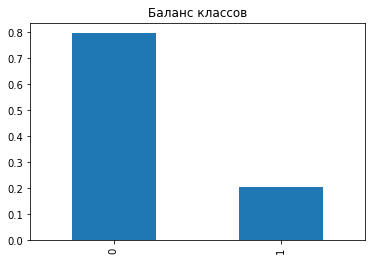

In [14]:
class_frequency.plot(kind='bar', title='Баланс классов')

**Вывод:** Наблюдается дисбаланс классов, положительный класс проявляется реже в соотношении 20:80 (или 1:4).

In [16]:
data = df.drop(['rownumber', 'customerid', 'surname'], axis=1) # уберем лишние столбцы

In [17]:
data_ohe = pd.get_dummies(data, drop_first=True) 
# преобразовываем категориальные признаки в численные техникой прямого кодирования (One-Hot Encoding) с избежанием дамми-ловушки
# иначе модель не сможет обучиться на категориальных признаках
features_logreg = data_ohe.drop(['exited'], axis=1) 
target_logreg = data_ohe['exited']
# у нас ситуация, когда есть исходные данные и нужно их поделить на 3 выборки: делим в соотношении 3:1:1 (60%, 20%, 20%). 
# Метод train_test_split не дает возможности сразу разделить данные на 3 части, поэтому применяем его 2 раза последовательно:  
features_train_valid_logreg, features_test_logreg, target_train_valid_logreg, target_test_logreg = train_test_split(
    features_logreg, target_logreg, test_size=0.2, random_state=12345) # отделяем 20% данных для тестовой выборки
features_train_logreg, features_valid_logreg, target_train_logreg, target_valid_logreg = train_test_split(
    features_train_valid_logreg, target_train_valid_logreg, test_size=0.25, random_state=12345) # отделяем 20% (25% от оставшихся) 
                                                                                  # данных для валидационной выборки
    
numeric = ['creditscore', 'age', 'tenure','balance', 'numofproducts', 'estimatedsalary']
# для логистической регрессии числовые признаки стандартизируем (масштабируем), чтобы у них были равные веса при тренировке модели
scaler = StandardScaler()
scaler.fit(features_train_logreg[numeric])
features_train_logreg[numeric] = scaler.transform(features_train_logreg[numeric])
features_valid_logreg[numeric] = scaler.transform(features_valid_logreg[numeric])
features_test_logreg[numeric] = scaler.transform(features_test_logreg[numeric])

In [18]:
print(features_train_logreg.shape) # проверяем, достаточны ли размеры выборок
print(features_valid_logreg.shape)
print(features_test_logreg.shape)

(5454, 11)
(1818, 11)
(1819, 11)


In [24]:
logreg = LogisticRegression(random_state=12345, solver='liblinear') # обучаем логистическую регрессию без учета дисбаланса классов
logreg.fit(features_train_logreg, target_train_logreg)
predicted_valid_logreg = logreg.predict(features_valid_logreg)

print('Значение F1-меры:', round(f1_score(target_valid_logreg, predicted_valid_logreg), 4)) # выводим значение F1 меры

probabilities_valid_logreg = logreg.predict_proba(features_valid_logreg)
probabilities_one_valid_logreg = probabilities_valid_logreg[:, 1]

print('Значение AUC-ROC:', round(roc_auc_score(target_valid_logreg, probabilities_one_valid_logreg), 4)) # выводим значение AUC-ROC

Значение F1-меры: 0.3004
Значение AUC-ROC: 0.7726


**Для логистической регрессии без учета дисбаланса классов результаты следующие:** 
Метрика f1 довольно низкая, а значит качество прогноза положительного результата низкое хотя бы по одной из метрик (точность / полнота) или по обеим. AUC-ROC в 1.5 раза выше, чем у случайной модели, но еще есть, к чему стремиться.

In [23]:
encoder = OrdinalEncoder() 
# хоть техника OHE и универсальная для разных моделей, но для дерева решений и случайного леса есть техника порядкового кодирования, 
# применим ее, поэтому для деревьев и леса поделим данные по новой, с учетом другой техники преобразования кат. признаков
data_ordinal = pd.DataFrame(encoder.fit_transform(data), 
                                                      columns=data.columns)
features_ranfor = data_ordinal.drop(['exited'], axis=1) 
target_ranfor = data_ordinal['exited']
# у нас ситуация, когда есть исходные данные и нужно их поделить на 3 выборки: делим в соотношении 3:1:1 (60%, 20%, 20%). 
# Метод train_test_split не дает возможности сразу разделить данные на 3 части, поэтому применяем его 2 раза последовательно:  
features_train_valid_ranfor, features_test_ranfor, target_train_valid_ranfor, target_test_ranfor = train_test_split(
    features_ranfor, target_ranfor, test_size=0.2, random_state=12345) # отделяем 20% данных для тестовой выборки
features_train_ranfor, features_valid_ranfor, target_train_ranfor, target_valid_ranfor = train_test_split(
    features_train_valid_ranfor, target_train_valid_ranfor, test_size=0.25, random_state=12345) # отделяем 20% (25% от оставшихся) 
                                                                                  # данных для валидационной выборки
data_ordinal # выводим получившийся датафрейм, чтобы оценить, что все прошло без ошибок

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,226.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,4609.0,1.0
1,215.0,2.0,0.0,23.0,1.0,679.0,0.0,0.0,1.0,5119.0,0.0
2,109.0,0.0,0.0,24.0,8.0,5277.0,2.0,1.0,0.0,5182.0,1.0
3,306.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4274.0,0.0
4,457.0,2.0,0.0,25.0,2.0,3374.0,0.0,1.0,1.0,3559.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9086,407.0,0.0,0.0,11.0,2.0,0.0,1.0,0.0,0.0,7599.0,0.0
9087,378.0,0.0,1.0,21.0,5.0,0.0,1.0,1.0,0.0,4385.0,0.0
9088,123.0,0.0,1.0,17.0,10.0,110.0,0.0,1.0,1.0,4627.0,0.0
9089,316.0,0.0,0.0,18.0,7.0,0.0,0.0,0.0,1.0,1882.0,1.0


In [73]:
best_tree_model = None
best_tree_f1 = 0
best_tree_aucroc = 0
best_tree_depth = 0
for depth in range(1, 11):
    detree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    detree.fit(features_train_ranfor, target_train_ranfor) # обучаем модель на тренировочной выборке
    predicted_valid_detree = detree.predict(features_valid_ranfor) # считаем метрики модели на валидационной выборке
    f1 = round(f1_score(target_valid_ranfor, predicted_valid_detree), 4)
    probabilities_valid_detree = detree.predict_proba(features_valid_ranfor)
    probabilities_one_valid_detree = probabilities_valid_detree[:, 1]
    aucroc = round(roc_auc_score(target_valid_ranfor, probabilities_one_valid_detree), 4)
    if f1 > best_tree_f1:
        best_tree_model = detree # сохраняем наилучшую модель
        best_tree_f1 = f1 #  сохраняем наилучшее значение F1-меры на валидационных данных
        best_tree_aucroc = aucroc #  сохраняем значение AUC-ROC лучшей модели на валидационных данных
        best_tree_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
print(best_tree_depth, '- оптимальная глубина дерева') 
print(best_tree_f1, '- F1-мера лучшего дерева решений на валидационной выборке')
print(best_tree_aucroc, '- значение AUC-ROC')

5 - оптимальная глубина дерева
0.5303 - F1-мера лучшего дерева решений на валидационной выборке
0.8141 - значение AUC-ROC


**Для дерева решений без учета дисбаланса классов результаты следующие:** 
Метрика f1 почти в 2 раза выше, чем для логистической регрессии, но все еще ниже целевого уровня в 0.59, а значит качество прогноза положительного результата пока ниже, чем хотелось бы. AUC-ROC немного выше, чем у логистической регрессии, но еще есть, к чему стремиться.

In [81]:
best_forest_model = None
best_forest_f1 = 0
best_forest_aucroc = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 101, 10):
    for depth in range (1, 21, 1):
        ranfor = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        ranfor.fit(features_train_ranfor, target_train_ranfor) # обучаем модель на тренировочной выборке
        predicted_valid_ranfor = ranfor.predict(features_valid_ranfor)
        f1 = round(f1_score(target_valid_ranfor, predicted_valid_ranfor), 4) # считаем метрики модели на валидационной в-ке
        probabilities_valid_ranfor = ranfor.predict_proba(features_valid_ranfor)
        probabilities_one_valid_ranfor = probabilities_valid_ranfor[:, 1]
        aucroc = round(roc_auc_score(target_valid_ranfor, probabilities_one_valid_ranfor), 4)
        if f1 > best_forest_f1:
            best_forest_model = ranfor # сохраняем наилучшую модель
            best_forest_f1 = f1 #  сохраняем наилучшее значение F1-меры на валидационных данных
            best_forest_aucroc = aucroc #  сохраняем значение AUC-ROC лучшей модели на валидационных данных
            best_forest_est = est #  сохраняем наилучшее значение гиперпараметра n_estimators на валидационных данных
            best_forest_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
print(best_forest_est, '- лучшее количество деревьев')
print(best_forest_depth, '- лучшая глубина деревьев') 
print(best_forest_f1, '- F1-мера лучшего случайного леса на валидационной выборке')
print(best_forest_aucroc, '- значение AUC-ROC')

40 - лучшее количество деревьев
16 - лучшая глубина деревьев
0.5597 - F1-мера лучшего случайного леса на валидационной выборке
0.8257 - значение AUC-ROC


**Для случайного леса классификации без учета дисбаланса классов результаты следующие:** 
Метрика f1 немного выше, чем для дерева решений, но все еще ниже целевого уровня в 0.59, а значит качество прогноза положительного результата пока ниже, чем хотелось бы. AUC-ROC немного выше, чем у дерева решений, но все еще есть, к чему стремиться.

## Борьба с дисбалансом

### Взвешивание классов

In [57]:
# обучаем логистическую регрессию c учетом дисбаланса классов

logreg = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') 
logreg.fit(features_train_logreg, target_train_logreg)
predicted_valid_logreg = logreg.predict(features_valid_logreg)

print('Значение F1-меры:', round(f1_score(target_valid_logreg, predicted_valid_logreg), 4)) # выводим значение F1 меры

probabilities_valid_logreg = logreg.predict_proba(features_valid_logreg)
probabilities_one_valid_logreg = probabilities_valid_logreg[:, 1]

print('Значение AUC-ROC:', round(roc_auc_score(target_valid_logreg, probabilities_one_valid_logreg), 4)) # выводим значение AUC-ROC

Значение F1-меры: 0.4951
Значение AUC-ROC: 0.7748


In [83]:
best_tree_model = None
best_tree_f1 = 0
best_tree_aucroc = 0
best_tree_depth = 0
for depth in range(1, 11):
    detree = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') 
    detree.fit(features_train_ranfor, target_train_ranfor) # обучаем модель на тренировочной выборке
    predicted_valid_detree = detree.predict(features_valid_ranfor) # считаем метрики модели на валидационной выборке
    f1 = round(f1_score(target_valid_ranfor, predicted_valid_detree), 4)
    probabilities_valid_detree = detree.predict_proba(features_valid_ranfor)
    probabilities_one_valid_detree = probabilities_valid_detree[:, 1]
    aucroc = round(roc_auc_score(target_valid_ranfor, probabilities_one_valid_detree), 4)
    if f1 > best_tree_f1:
        best_tree_model = detree # сохраняем наилучшую модель
        best_tree_f1 = f1 #  сохраняем наилучшее значение F1-меры на валидационных данных
        best_tree_aucroc = aucroc #  сохраняем значение AUC-ROC лучшей модели на валидационных данных
        best_tree_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
print(best_tree_depth, '- оптимальная глубина дерева') 
print(best_tree_f1, '- F1-мера лучшего дерева решений на валидационной выборке')
print(best_tree_aucroc, '- значение AUC-ROC')

5 - оптимальная глубина дерева
0.5624 - F1-мера лучшего дерева решений на валидационной выборке
0.8126 - значение AUC-ROC


In [85]:
best_forest_model = None
best_forest_f1 = 0
best_forest_aucroc = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 101, 10):
    for depth in range (1, 21, 1):
        ranfor = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        ranfor.fit(features_train_ranfor, target_train_ranfor) # обучаем модель на тренировочной выборке
        predicted_valid_ranfor = ranfor.predict(features_valid_ranfor)
        f1 = round(f1_score(target_valid_ranfor, predicted_valid_ranfor), 4) # считаем метрики модели на валидационной в-ке
        probabilities_valid_ranfor = ranfor.predict_proba(features_valid_ranfor)
        probabilities_one_valid_ranfor = probabilities_valid_ranfor[:, 1]
        aucroc = round(roc_auc_score(target_valid_ranfor, probabilities_one_valid_ranfor), 4)
        if f1 > best_forest_f1:
            best_forest_model = ranfor # сохраняем наилучшую модель
            best_forest_f1 = f1 #  сохраняем наилучшее значение F1-меры на валидационных данных
            best_forest_aucroc = aucroc #  сохраняем значение AUC-ROC лучшей модели на валидационных данных
            best_forest_est = est #  сохраняем наилучшее значение гиперпараметра n_estimators на валидационных данных
            best_forest_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
print(best_forest_est, '- лучшее количество деревьев')
print(best_forest_depth, '- лучшая глубина деревьев') 
print(best_forest_f1, '- F1-мера лучшего случайного леса на валидационной выборке')
print(best_forest_aucroc, '- значение AUC-ROC')

80 - лучшее количество деревьев
8 - лучшая глубина деревьев
0.6018 - F1-мера лучшего случайного леса на валидационной выборке
0.8473 - значение AUC-ROC


**Вывод:** для случайного леса оказалось достаточным применить гиперпараметр class_weight='balanced', чтобы учесть дисбаланс классов и достичь значения F1-меры выше 0.59 (пока на валидационной выборке). Далее проверим его на тестовой выборке. Для логистической регрессии и дерева решений данный гиперпараметр улучшил показатели, но они по прежнему ниже требуемого уровня. Попробуем другие способы.

### Upsampling

In [35]:
# объявим функцию, которая увеличит кол-во положительного признака в обучающей выборке и перемешает данные, подготовив к обучению
# кол-во положительного класса увеличиваем в 4 раза, исходя из результатов исследования баланса классов выше

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [89]:
# обучаем логистическую регрессию с учетом увеличенной выборки

features_upsampled_logreg, target_upsampled_logreg = upsample(features_train_logreg, target_train_logreg, 4)

logreg = LogisticRegression(solver='liblinear', random_state=12345)

logreg.fit(features_upsampled_logreg, target_upsampled_logreg)

predicted_valid_logreg = logreg.predict(features_valid_logreg)

print('Значение F1-меры:', round(f1_score(target_valid_logreg, predicted_valid_logreg), 4))

Значение F1-меры: 0.4957


**Вывод:** При увеличении выборки метрика F1 для логистической регрессии еще немного увеличилась по сравнению со взвешиванием классов.

In [37]:
# для дерева решений и случайного леса делаем увеличение выборки отдельно

features_upsampled_ranfor, target_upsampled_ranfor = upsample(features_train_ranfor, target_train_ranfor, 4)

In [90]:
best_tree_model = None
best_tree_f1 = 0
best_tree_aucroc = 0
best_tree_depth = 0
for depth in range(1, 11):
    detree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    detree.fit(features_upsampled_ranfor, target_upsampled_ranfor) # обучаем модель на тренировочной выборке
    predicted_valid_detree = detree.predict(features_valid_ranfor) # считаем метрики модели на валидационной выборке
    f1 = round(f1_score(target_valid_ranfor, predicted_valid_detree), 4)
    probabilities_valid_detree = detree.predict_proba(features_valid_ranfor)
    probabilities_one_valid_detree = probabilities_valid_detree[:, 1]
    aucroc = round(roc_auc_score(target_valid_ranfor, probabilities_one_valid_detree), 4)
    if f1 > best_tree_f1:
        best_tree_model = detree # сохраняем наилучшую модель
        best_tree_f1 = f1 #  сохраняем наилучшее значение F1-меры на валидационных данных
        best_tree_aucroc = aucroc #  сохраняем значение AUC-ROC лучшей модели на валидационных данных
        best_tree_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
print(best_tree_depth, '- оптимальная глубина дерева') 
print(best_tree_f1, '- F1-мера лучшего дерева решений на валидационной выборке')
print(best_tree_aucroc, '- значение AUC-ROC')

5 - оптимальная глубина дерева
0.5624 - F1-мера лучшего дерева решений на валидационной выборке
0.8126 - значение AUC-ROC


**Вывод:** При увеличении выборки метрика F1 для дерева решения такая же, как при взвешивании классов.

In [92]:
best_forest_model = None
best_forest_f1 = 0
best_forest_aucroc = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 101, 10):
    for depth in range (1, 21, 1):
        ranfor = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        ranfor.fit(features_upsampled_ranfor, target_upsampled_ranfor) # обучаем модель на тренировочной выборке
        predicted_valid_ranfor = ranfor.predict(features_valid_ranfor)
        f1 = round(f1_score(target_valid_ranfor, predicted_valid_ranfor), 4) # считаем метрики модели на валидационной в-ке
        probabilities_valid_ranfor = ranfor.predict_proba(features_valid_ranfor)
        probabilities_one_valid_ranfor = probabilities_valid_ranfor[:, 1]
        aucroc = round(roc_auc_score(target_valid_ranfor, probabilities_one_valid_ranfor), 4)
        if f1 > best_forest_f1:
            best_forest_model = ranfor # сохраняем наилучшую модель
            best_forest_f1 = f1 #  сохраняем наилучшее значение F1-меры на валидационных данных
            best_forest_aucroc = aucroc #  сохраняем значение AUC-ROC лучшей модели на валидационных данных
            best_forest_est = est #  сохраняем наилучшее значение гиперпараметра n_estimators на валидационных данных
            best_forest_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
print(best_forest_est, '- лучшее количество деревьев')
print(best_forest_depth, '- лучшая глубина деревьев') 
print(best_forest_f1, '- F1-мера лучшего случайного леса на валидационной выборке')
print(best_forest_aucroc, '- значение AUC-ROC')

40 - лучшее количество деревьев
18 - лучшая глубина деревьев
0.5942 - F1-мера лучшего случайного леса на валидационной выборке
0.835 - значение AUC-ROC


**Вывод:** При увеличении выборки метрика F1 для случайного леса хуже, чем при взвешивании классов, однако тоже выше требуемого значения.

### Downsampling

In [43]:
# объявим функцию, которая уменьшит кол-во отрицательного признака в обучающей выборке и перемешает данные, подготовив к обучению
# кол-во отрицательного класса уменьшаем в 4 раза, исходя из результатов исследования баланса классов выше

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [95]:
# обучаем логистическую регрессию с учетом уменьшенной выборки

features_downsampled_logreg, target_downsampled_logreg = downsample(features_train_logreg, target_train_logreg, 0.25)

logreg = LogisticRegression(solver='liblinear', random_state=12345)
logreg.fit(features_downsampled_logreg, target_downsampled_logreg)

predicted_valid_logreg = logreg.predict(features_valid_logreg)

print('Значение F1-меры:', round(f1_score(target_valid_logreg, predicted_valid_logreg), 4))

Значение F1-меры: 0.5


**Вывод:** При уменьшении выборки для логистической регрессии, метрика F1 еще немного увеличилась по сравнению с увеличением.

In [45]:
# для дерева решений и случайного леса делаем уменьшение выборки отдельно

features_downsampled_ranfor, target_downsampled_ranfor = downsample(features_train_ranfor, target_train_ranfor, 0.25)

In [96]:
best_tree_model = None
best_tree_f1 = 0
best_tree_aucroc = 0
best_tree_depth = 0
for depth in range(1, 11):
    detree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    detree.fit(features_downsampled_ranfor, target_downsampled_ranfor) # обучаем модель на тренировочной выборке
    predicted_valid_detree = detree.predict(features_valid_ranfor) # считаем метрики модели на валидационной выборке
    f1 = round(f1_score(target_valid_ranfor, predicted_valid_detree), 4)
    probabilities_valid_detree = detree.predict_proba(features_valid_ranfor)
    probabilities_one_valid_detree = probabilities_valid_detree[:, 1]
    aucroc = round(roc_auc_score(target_valid_ranfor, probabilities_one_valid_detree), 4)
    if f1 > best_tree_f1:
        best_tree_model = detree # сохраняем наилучшую модель
        best_tree_f1 = f1 #  сохраняем наилучшее значение F1-меры на валидационных данных
        best_tree_aucroc = aucroc #  сохраняем значение AUC-ROC лучшей модели на валидационных данных
        best_tree_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
print(best_tree_depth, '- оптимальная глубина дерева') 
print(best_tree_f1, '- F1-мера лучшего дерева решений на валидационной выборке')
print(best_tree_aucroc, '- значение AUC-ROC')

5 - оптимальная глубина дерева
0.5532 - F1-мера лучшего дерева решений на валидационной выборке
0.8095 - значение AUC-ROC


**Вывод:** При уменьшении выборки метрика F1 для дерева решений ухудшилась по сравнению с увеличением выборки.

In [98]:
best_forest_model = None
best_forest_f1 = 0
best_forest_aucroc = 0
best_forest_est = 0
best_forest_depth = 0
for est in range(10, 101, 10):
    for depth in range (1, 21, 1):
        ranfor = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        ranfor.fit(features_downsampled_ranfor, target_downsampled_ranfor) # обучаем модель на тренировочной выборке
        predicted_valid_ranfor = ranfor.predict(features_valid_ranfor)
        f1 = round(f1_score(target_valid_ranfor, predicted_valid_ranfor), 4) # считаем метрики модели на валидационной в-ке
        probabilities_valid_ranfor = ranfor.predict_proba(features_valid_ranfor)
        probabilities_one_valid_ranfor = probabilities_valid_ranfor[:, 1]
        aucroc = round(roc_auc_score(target_valid_ranfor, probabilities_one_valid_ranfor), 4)
        if f1 > best_forest_f1:
            best_forest_model = ranfor # сохраняем наилучшую модель
            best_forest_f1 = f1 #  сохраняем наилучшее значение F1-меры на валидационных данных
            best_forest_aucroc = aucroc #  сохраняем значение AUC-ROC лучшей модели на валидационных данных
            best_forest_est = est #  сохраняем наилучшее значение гиперпараметра n_estimators на валидационных данных
            best_forest_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
print(best_forest_est, '- лучшее количество деревьев')
print(best_forest_depth, '- лучшая глубина деревьев') 
print(best_forest_f1, '- F1-мера лучшего случайного леса на валидационной выборке')
print(best_forest_aucroc, '- значение AUC-ROC')

20 - лучшее количество деревьев
16 - лучшая глубина деревьев
0.5845 - F1-мера лучшего случайного леса на валидационной выборке
0.8331 - значение AUC-ROC


**Вывод:** При уменьшении выборки метрика F1 для случайного леса ухудшилась по сравнению с увеличением выборки.

### Изменение порога

In [106]:
# для обученной догистической регрессии переберем значения порога и посмотрим, как они вияют на значение F1-меры:

logreg = LogisticRegression(random_state=12345, solver='liblinear')
logreg.fit(features_train_logreg, target_train_logreg)
probabilities_valid_logreg = logreg.predict_proba(features_valid_logreg)
probabilities_one_valid_logreg = probabilities_valid_logreg[:, 1]

for threshold in np.arange(0, 0.4, 0.02):
    predicted_valid_logreg = probabilities_one_valid_logreg > threshold  
    f1_logreg = f1_score(target_valid_logreg, predicted_valid_logreg)
    precision_logreg = precision_score(target_valid_logreg, predicted_valid_logreg)
    recall_logreg = recall_score(target_valid_logreg, predicted_valid_logreg)
    
    print("Порог = {:.2f} | F1-мера = {:.4f}, Точность = {:.4f}, Полнота = {:.4f}".format(
        threshold, f1_logreg, precision_logreg, recall_logreg))

Порог = 0.00 | F1-мера = 0.3352, Точность = 0.2013, Полнота = 1.0000
Порог = 0.02 | F1-мера = 0.3347, Точность = 0.2011, Полнота = 0.9973
Порог = 0.04 | F1-мера = 0.3435, Точность = 0.2079, Полнота = 0.9863
Порог = 0.06 | F1-мера = 0.3685, Точность = 0.2273, Полнота = 0.9727
Порог = 0.08 | F1-мера = 0.3964, Точность = 0.2500, Полнота = 0.9563
Порог = 0.10 | F1-мера = 0.4188, Точность = 0.2706, Полнота = 0.9262
Порог = 0.12 | F1-мера = 0.4411, Точность = 0.2949, Полнота = 0.8743
Порог = 0.14 | F1-мера = 0.4539, Точность = 0.3119, Полнота = 0.8333
Порог = 0.16 | F1-мера = 0.4711, Точность = 0.3357, Полнота = 0.7896
Порог = 0.18 | F1-мера = 0.4777, Точность = 0.3514, Полнота = 0.7459
Порог = 0.20 | F1-мера = 0.4828, Точность = 0.3717, Полнота = 0.6885
Порог = 0.22 | F1-мера = 0.4974, Точность = 0.3987, Полнота = 0.6612
Порог = 0.24 | F1-мера = 0.4939, Точность = 0.4165, Полнота = 0.6066
Порог = 0.26 | F1-мера = 0.4988, Точность = 0.4396, Полнота = 0.5765
Порог = 0.28 | F1-мера = 0.4840, Т

**Вывод:** При изменении порога не удалось добиться улучшения метрики F1 по сравнению с уменьшением выборки.

In [107]:
# для обученного дерева решений переберем значения порога и посмотрим, как они вияют на значение F1-меры:

detree = DecisionTreeClassifier(max_depth=5, random_state=12345)
detree.fit(features_train_ranfor, target_train_ranfor)
probabilities_valid_detree = detree.predict_proba(features_valid_ranfor)
probabilities_one_valid_detree = probabilities_valid_detree[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid_detree = probabilities_one_valid_detree > threshold # 
    f1_detree = f1_score(target_valid_ranfor, predicted_valid_detree) # 
    precision_detree = precision_score(target_valid_ranfor, predicted_valid_detree)
    recall_detree = recall_score(target_valid_ranfor, predicted_valid_detree)
    
    print("Порог = {:.2f} | F1-мера = {:.4f}, Точность = {:.4f}, Полнота = {:.4f}".format(
        threshold, f1_detree, precision_detree, recall_detree))

Порог = 0.00 | F1-мера = 0.3344, Точность = 0.2009, Полнота = 0.9973
Порог = 0.02 | F1-мера = 0.3643, Точность = 0.2231, Полнота = 0.9918
Порог = 0.04 | F1-мера = 0.3964, Точность = 0.2504, Полнота = 0.9508
Порог = 0.06 | F1-мера = 0.4278, Точность = 0.2784, Полнота = 0.9235
Порог = 0.08 | F1-мера = 0.4251, Точность = 0.2769, Полнота = 0.9153
Порог = 0.10 | F1-мера = 0.4648, Точность = 0.3152, Полнота = 0.8852
Порог = 0.12 | F1-мера = 0.4648, Точность = 0.3152, Полнота = 0.8852
Порог = 0.14 | F1-мера = 0.4823, Точность = 0.3358, Полнота = 0.8552
Порог = 0.16 | F1-мера = 0.4871, Точность = 0.3451, Полнота = 0.8279
Порог = 0.18 | F1-мера = 0.5230, Точность = 0.4119, Полнота = 0.7158
Порог = 0.20 | F1-мера = 0.5230, Точность = 0.4119, Полнота = 0.7158
Порог = 0.22 | F1-мера = 0.5230, Точность = 0.4119, Полнота = 0.7158
Порог = 0.24 | F1-мера = 0.5515, Точность = 0.5407, Полнота = 0.5628
Порог = 0.26 | F1-мера = 0.5515, Точность = 0.5407, Полнота = 0.5628
Порог = 0.28 | F1-мера = 0.5673, Т

**Вывод:** При изменении порога для дерева решений возможно добиться небольшого улучшения метрики F1 по сравнению со взвешиванием классов, однако целевой показатель меры все равно не достигнут.

In [108]:
# для обученного случайного леса переберем значения порога и посмотрим, как они вияют на значение F1-меры:

ranfor = RandomForestClassifier(n_estimators=40, max_depth=16, random_state=12345)
ranfor.fit(features_train_ranfor, target_train_ranfor)
probabilities_valid_ranfor = ranfor.predict_proba(features_valid_ranfor)
probabilities_one_valid_ranfor = probabilities_valid_ranfor[:, 1]

for threshold in np.arange(0, 0.4, 0.02):
    predicted_valid_ranfor = probabilities_one_valid_ranfor > threshold 
    f1_ranfor = f1_score(target_valid_ranfor, predicted_valid_ranfor) 
    precision_ranfor = precision_score(target_valid_ranfor, predicted_valid_ranfor)
    recall_ranfor = recall_score(target_valid_ranfor, predicted_valid_ranfor)
    
    print("Порог = {:.2f} | F1-мера = {:.4f}, Точность = {:.4f}, Полнота = {:.4f}".format(
        threshold, f1_ranfor, precision_ranfor, recall_ranfor))

Порог = 0.00 | F1-мера = 0.3603, Точность = 0.2199, Полнота = 0.9973
Порог = 0.02 | F1-мера = 0.3766, Точность = 0.2328, Полнота = 0.9863
Порог = 0.04 | F1-мера = 0.4091, Точность = 0.2602, Полнота = 0.9563
Порог = 0.06 | F1-мера = 0.4336, Точность = 0.2833, Полнота = 0.9235
Порог = 0.08 | F1-мера = 0.4544, Точность = 0.3057, Полнота = 0.8852
Порог = 0.10 | F1-мера = 0.4737, Точность = 0.3268, Полнота = 0.8607
Порог = 0.12 | F1-мера = 0.4841, Точность = 0.3412, Полнота = 0.8333
Порог = 0.14 | F1-мера = 0.4949, Точность = 0.3582, Полнота = 0.8005
Порог = 0.16 | F1-мера = 0.5098, Точность = 0.3783, Полнота = 0.7814
Порог = 0.18 | F1-мера = 0.5217, Точность = 0.3988, Полнота = 0.7541
Порог = 0.20 | F1-мера = 0.5387, Точность = 0.4261, Полнота = 0.7322
Порог = 0.22 | F1-мера = 0.5468, Точность = 0.4444, Полнота = 0.7104
Порог = 0.24 | F1-мера = 0.5559, Точность = 0.4674, Полнота = 0.6858
Порог = 0.26 | F1-мера = 0.5612, Точность = 0.4860, Полнота = 0.6639
Порог = 0.28 | F1-мера = 0.5749, Т

**Вывод:** При изменении порога для случайного леса точно возможно добиться улучшения метрики F1 по сравнению с увеличением и уменьшением выборки, однако целевой показатель меры все равно не достигнут. Можно было бы еще поэкспериментировать с изменением параметров, однако метод взвешивания классов проще и уже дал нам нужный результат. Переходим к тестированию лучшей модели. Если оно не подтвердит результат, то будем искать дальше. 

**Промежуточный вывод:** Итак, если для логистической регрессии худший показатель F1-меры достигнут при взвешивании классов (0.4951), а лучший при уменьшении выборки (0.5), то для "деревянных" моделей, наоборот: уменьшение выборки дает худший результат (0.5532 для дерева и 0.5845 для леса), а лучший показатель F1-меры достигается при взвешивании классов (0.5624 для дерева и 0.6018 для леса), однако, стоит оговориться, что для дерева решений показатель при увеличении выборки такой же, как и при взвешивании классов, а для случайного леса он хоть и несколько ниже (0.5942), но тоже достигает заданного минимального уровня.
Лучшей моделью, согласно проверке на валидационной выборке, стал случайный лес с количеством деревьев 80 и максимальной глубиной 8 с использованием тактики взвешивания классов для борьбы с дисбалансом. Проверим ее на тестовой выборке и сравним с константной моделью.

## Тестирование модели

In [154]:
# обучаем случайный лес с учетом дисбаланса классов, используя гиперпараметры подобранные ранее и проверяем на тестовой выборке

ranfor = RandomForestClassifier(n_estimators=80, max_depth=8, random_state=12345, class_weight='balanced')
ranfor.fit(features_train_ranfor, target_train_ranfor)
predicted_test_ranfor = ranfor.predict(features_test_ranfor)

print('Значение F1-меры:', round(f1_score(target_test_ranfor, predicted_test_ranfor), 4)) 

probabilities_test_ranfor = ranfor.predict_proba(features_test_ranfor)
probabilities_one_test_ranfor = probabilities_test_ranfor[:, 1]

print('Значение AUC-ROC:', round(roc_auc_score(target_test_ranfor, probabilities_one_test_ranfor), 4))

Значение F1-меры: 0.5943
Значение AUC-ROC: 0.8528


**Комментарий:** Цель достигнута - F1-мера выше 0.59. AUC-ROC 0.85 - это, конечно не 1, но достаточно хороший результат. Сравним нашу модель с константной (которая предсказывает все время одно значение - 1, так как для бизнес задачи нам требуется предсказать отток клиентов).

In [158]:
target_pred_constant = pd.Series([1] * len(target_test_ranfor))
print('Значение F1-меры для константной модели:', round(f1_score(target_test_ranfor, target_pred_constant), 4))

probabilities_one_test_constant = pd.Series([1] * len(target_test_ranfor))

print('Значение AUC-ROC для константной модели:', round(roc_auc_score(target_test_ranfor, probabilities_one_test_constant), 4))

Значение F1-меры для константной модели: 0.3373
Значение AUC-ROC для константной модели: 0.5


**Вывод:** Цель достигнута - F1-мера нашей модели при проверке на тестовой выборке выше 0.59. Наша модель на 75% превосходит константную по значению F1-меры и на 70% по значению AUC-ROC.